In [1]:
from subprocess import call
import numpy as np 
import matplotlib.pyplot as plt
from scipy import special 
from brokenaxes import brokenaxes

import sys
sys.path.append('src')
from src.utils import error, SpinChain

call(['gfortran', 'spin_chain.f90', '-O3', '-llapack', '-o', 'spin_chain'], cwd='src')
call(['gfortran', 'correl.f90', '-O3', '-lblas', '-llapack', '-o', 'correl'], cwd='src')

0

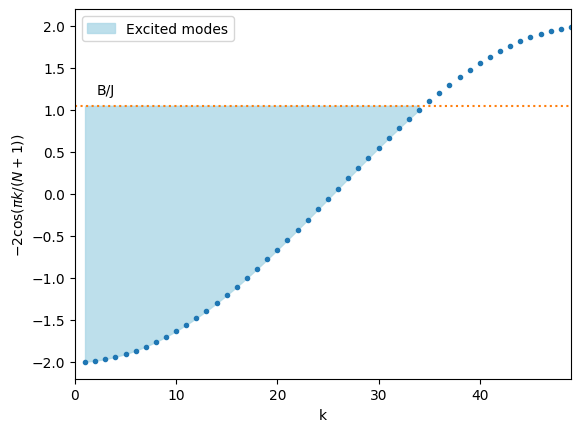

In [2]:
N = 50
J = 1
B = 1.05

kc = int(np.floor((N+1) * np.arccos(- B / (2*J)) / np.pi))
k = np.arange(1, N+1)
osc = - 2*np.cos(np.pi*k/(N+1))
plt.plot(k, osc, '.')
plt.plot([0, N], [B/J, B/J], ':')
plt.fill_between(k[:kc], osc[:kc], B/J, color='lightblue', alpha=.8, label='Excited modes')
plt.text(3, B/J + 0.1, 'B/J', ha='center', va='bottom') 
plt.xlabel('k')
plt.ylabel(r'$- 2\cos(\pi k/(N+1))$')
plt.xlim(0, N-1)
plt.ylim(-2.2, 2.2)
plt.legend()
plt.savefig('figures/homogeneous.png', bbox_inches='tight', dpi=200)

In [3]:
N = 400
M = N//2

a = 1 / (N-1)
n = np.arange(0, N-1)
u = np.arange(1,N+1)/N
v = np.arange(-N//2+1, N//2+1)/N

B = np.zeros(N)

J = np.ones(N-1)
x = N * u/2
homogeneous = SpinChain(N, J, B)
homogeneous.isothermal_length(x, 'l')

h = 1; J = np.exp(- h * np.abs(n/N - .5))
x = N/2 * np.sign(v) * (np.exp(h*np.abs(v)) - 1) / h 
rainbow = SpinChain(N, J, B)
rainbow.isothermal_length(x, 'c')

J = np.sqrt((1+n)/N * (1 - (1+n)/N))
x = N * np.arcsin(np.sqrt(u))
krawtchouk = SpinChain(N, J, B)
krawtchouk.isothermal_length(x, 'l')

J = np.sqrt(((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N))
x = N * special.ellipkinc(np.arcsin(2*v), (1 - 1/N)**2)
x[-1] = N * special.ellipk((1 - 1/N)**2)
lame = SpinChain(N, J, B)
lame.isothermal_length(x, 'c')

chains = [homogeneous, rainbow, krawtchouk, lame]
names = ['homogeneous', 'rainbow', 'krawtchouk', 'lame']

In [4]:
for chain, name in zip(chains, names):
    print('Chain: ', name)
    chain.diagonalise()
    chain.filling(M)

Chain:  homogeneous
Diagonalising L = 400 / 400
Chain:  rainbow
Diagonalising L = 400 / 400
Chain:  krawtchouk
Diagonalising L = 400 / 400
Chain:  lame
Diagonalising L = 400 / 400


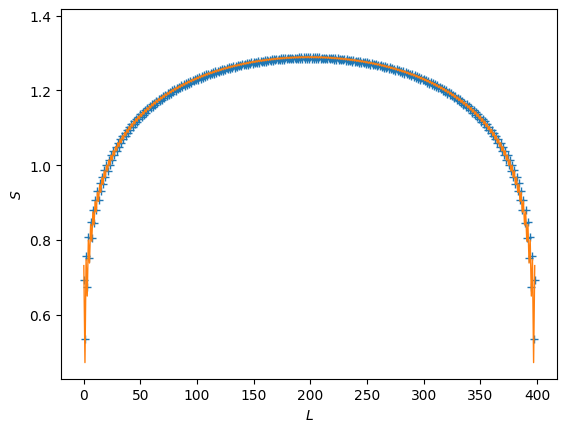

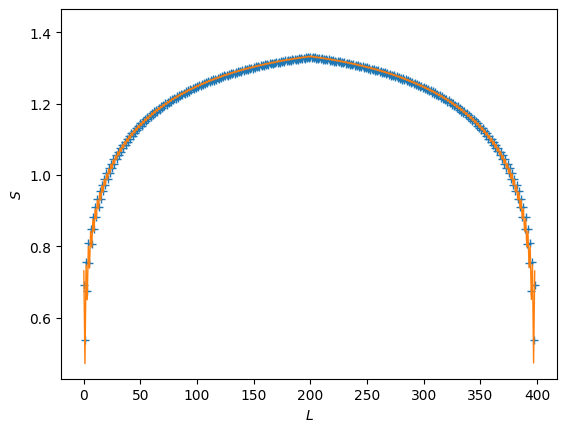

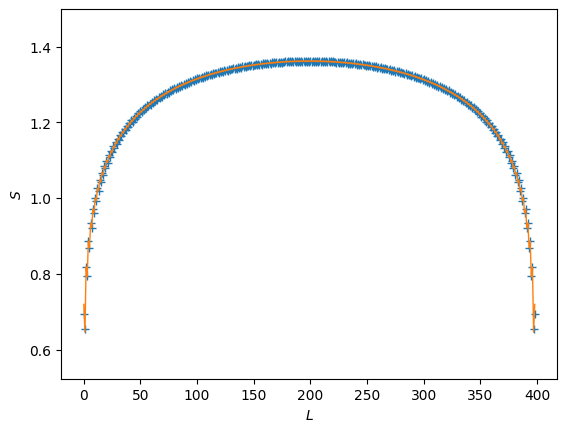

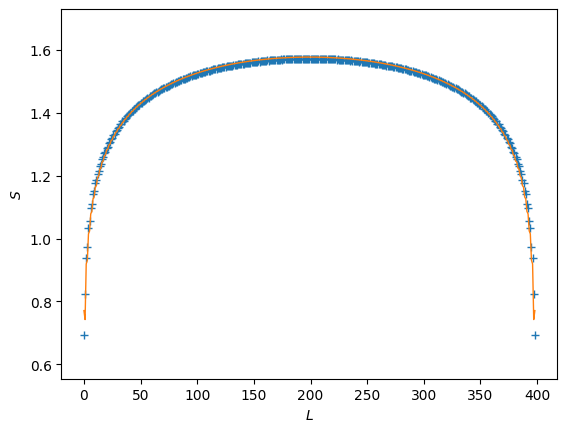

In [5]:
for chain, name in zip(chains, names):
    cp = np.mean((chain.S()[:-1] - chain.S0()))
    S_CFT = chain.S0() + chain.S1() + cp 

    plt.figure()
    plt.plot(chain.S()[:-1], '+')
    plt.plot(S_CFT, lw = 1)
    plt.xlabel('$L$')
    plt.ylabel('$S$')
    plt.ylim(.8 * np.min(chain.S()[:-1]), 1.1 * np.max(chain.S()[:-1]))
    plt.savefig(f'figures/{name}_1.png', bbox_inches='tight', dpi=200)

homogeneous 0.25 	 RMSE/MEAN = 1.1191
homogeneous 0.5 	 RMSE/MEAN = 0.3796
homogeneous 1 	 RMSE/MEAN = 0.5188
homogeneous 2 	 RMSE/MEAN = 0.7445
rainbow 0.25 	 RMSE/MEAN = 1.3023
rainbow 0.5 	 RMSE/MEAN = 0.3960
rainbow 1 	 RMSE/MEAN = 0.5138
rainbow 2 	 RMSE/MEAN = 0.7365
krawtchouk 0.25 	 RMSE/MEAN = 1.4640
krawtchouk 0.5 	 RMSE/MEAN = 0.5187
krawtchouk 1 	 RMSE/MEAN = 0.1555
krawtchouk 2 	 RMSE/MEAN = 0.1967
lame 0.25 	 RMSE/MEAN = 1.3737
lame 0.5 	 RMSE/MEAN = 0.5812
lame 1 	 RMSE/MEAN = 0.7200
lame 2 	 RMSE/MEAN = 1.0522


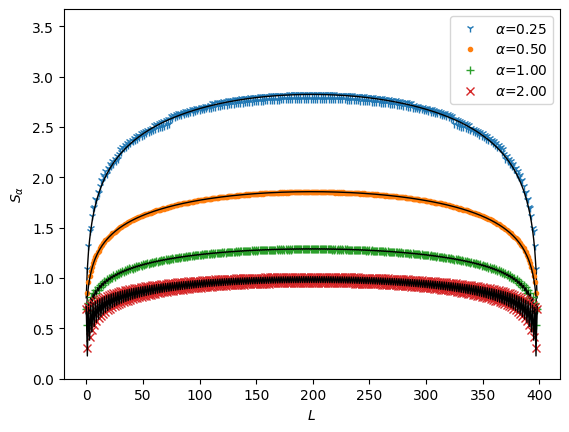

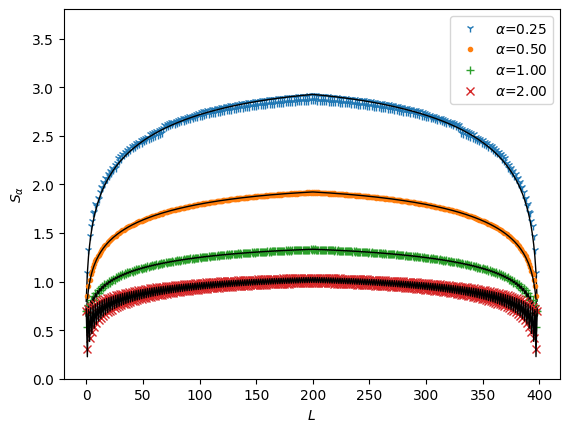

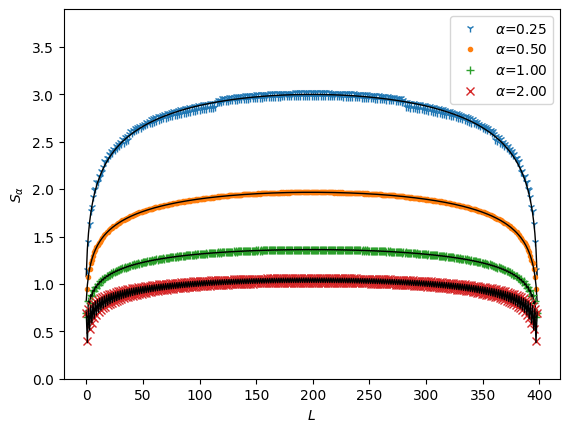

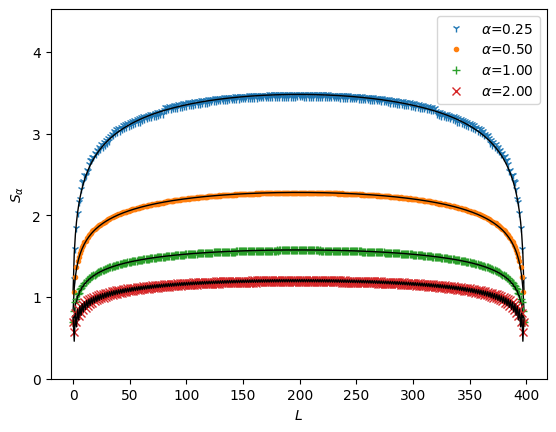

In [6]:
for chain, name in zip(chains, names):
    plt.figure()

    for a, m in zip([.25, .5, 1, 2], ['1', '.', '+', 'x']):
        S = chain.S(a)[:-1]
        cp = np.mean(S - chain.S0(a))
        S_CFT = chain.S0(a) + chain.S1(a) + cp 
        if a == .25:
            plt.ylim(0, 1.3*np.max(S_CFT))
        plt.plot(S, m, label=rf'$\alpha$={a:.2f}')
        plt.plot(S_CFT, 'k', lw = 1)
        RMSE, MEAN = error(S, S_CFT)
        print(name, a, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
    plt.xlabel('$L$')
    plt.ylabel(r'$S_\alpha$')
    plt.legend()
    plt.savefig(f'figures/{name}_a.png', bbox_inches='tight', dpi=200)

homogeneous 2 	 RMSE/MEAN = 0.7445
rainbow 2 	 RMSE/MEAN = 0.7365
krawtchouk 2 	 RMSE/MEAN = 0.1967
lame 2 	 RMSE/MEAN = 1.0522


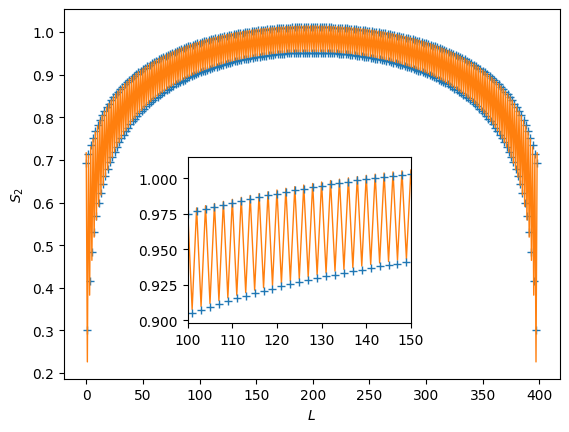

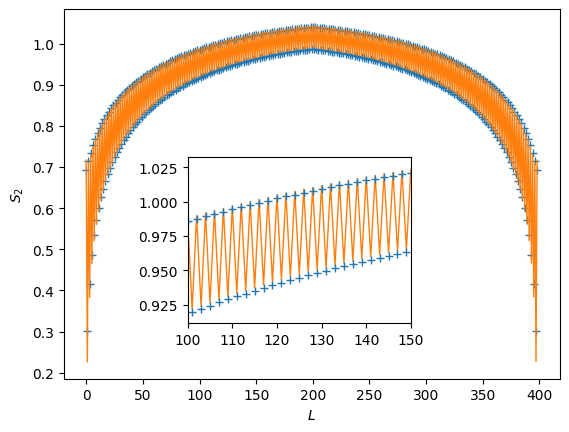

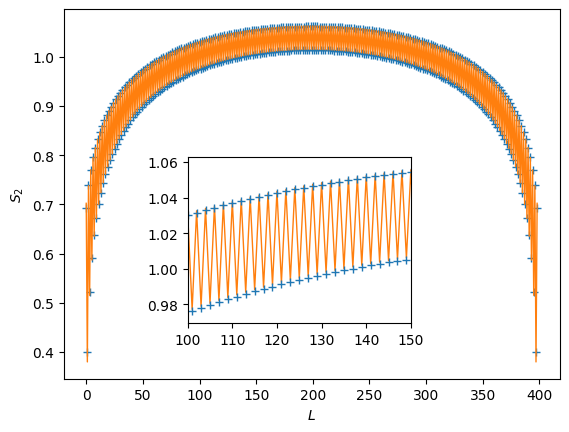

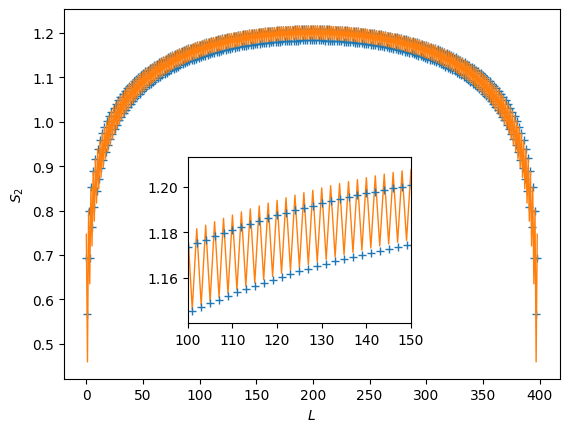

In [7]:
for chain, name in zip(chains, names):
    plt.figure()

    S = chain.S(2)[:-1]
    cp = np.mean((S - chain.S0(2)))
    S_CFT = chain.S0(2) + chain.S1(2) + cp 
    
    plt.plot(S, '+')
    plt.plot(S_CFT, lw = 1)
    plt.xlabel('$L$')
    plt.ylabel(r'$S_2$')

    # Create inset axes
    start = 100; stop = 150
    ax = plt.gca()
    axins = ax.inset_axes((0.25, 0.15, 0.45, 0.45))
    axins.plot(S, '+')
    axins.plot(S_CFT, lw=1, zorder=-10)
    axins.set_xlim(start, stop)
    y_min = min(S_CFT[100:150])
    y_max = max(S_CFT[100:150])
    padding = 0.1 * (y_max - y_min)
    axins.set_ylim(y_min - padding, y_max + padding)

    RMSE, MEAN = error(S, S_CFT)
    print(name, 2, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
    plt.savefig(f'figures/{name}_2.png', bbox_inches='tight', dpi=200)


 rainbow 0 	 RMSE/MEAN = 0.5188
Diagonalising L = 400 / 400

 rainbow 2 	 RMSE/MEAN = 0.5096
Diagonalising L = 400 / 400

 rainbow 5 	 RMSE/MEAN = 0.5004
Diagonalising L = 400 / 400

 rainbow 10 	 RMSE/MEAN = 0.4819
Diagonalising L = 400 / 400


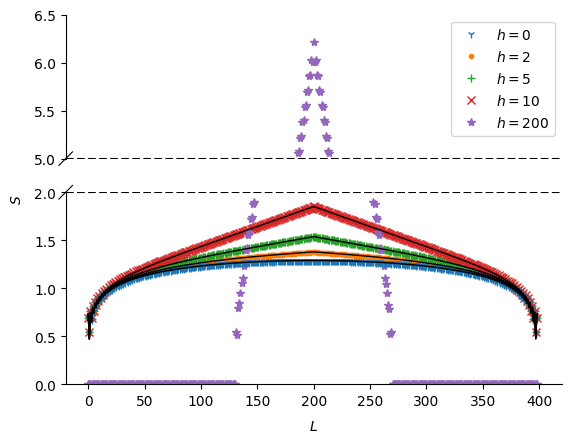

In [8]:
plt.figure()
c1 = 2
c2 = 5
bax = brokenaxes(xlims=((-20, 420),), ylims=((0, c1), (c2, 6.5)), wspace=.05)
bax.set_xlabel('$L$', labelpad=25)
bax.set_ylabel('$S$')
for h, m in zip([0, 2, 5, 10, 200], ['1', '.', '+', 'x', '*']):
    if h == 0:
        S = homogeneous.S()[:-1]
        cp = np.mean(S - homogeneous.S0())
        S_CFT = homogeneous.S0() + homogeneous.S1() + cp      
        bax.plot(S, m, label=f'$h={h}$')
        bax.plot(S_CFT, 'k', lw = 1)
        RMSE, MEAN = error(S, S_CFT)
        print('\n rainbow', h, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
    else:
        J = np.exp(- h * np.abs(n/N - .5))
        v = np.arange(-N//2+1, N//2+1)/N
        x = N/2 * np.sign(v) * (np.exp(h*np.abs(v)) - 1) / h 
        rainbow = SpinChain(N, J, B)
        rainbow.isothermal_length(x, 'c')
        rainbow.diagonalise()
        rainbow.filling(M)
        S = rainbow.S()[:-1]
        bax.plot(S, m, label=f'$h={h}$', zorder=-1)

        if h != 200:
            cp = np.mean(S - rainbow.S0())
            S_CFT = rainbow.S0() + rainbow.S1() + cp 
            bax.plot(S_CFT, 'k', lw = 1, zorder=100)
            RMSE, MEAN = error(S, S_CFT)
            print('\n rainbow', h, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')

bax.plot([-20, 420], [c1, c1], 'k--')
bax.plot([-20, 420], [c2, c2], 'k--')
bax.legend()
plt.savefig(f'figures/rainbow_h.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400

 25
Diagonalising L = 400 / 400

 50
Diagonalising L = 400 / 400

 100
Diagonalising L = 400 / 400

 200
Diagonalising L = 400 / 400

 25
Diagonalising L = 400 / 400

 50
Diagonalising L = 400 / 400

 100
Diagonalising L = 400 / 400

 200
Diagonalising L = 400 / 400

 25
Diagonalising L = 400 / 400

 50
Diagonalising L = 400 / 400

 100
Diagonalising L = 400 / 400

 200
Diagonalising L = 400 / 400

 25
Diagonalising L = 400 / 400

 50
Diagonalising L = 400 / 400

 100
Diagonalising L = 400 / 400

 200


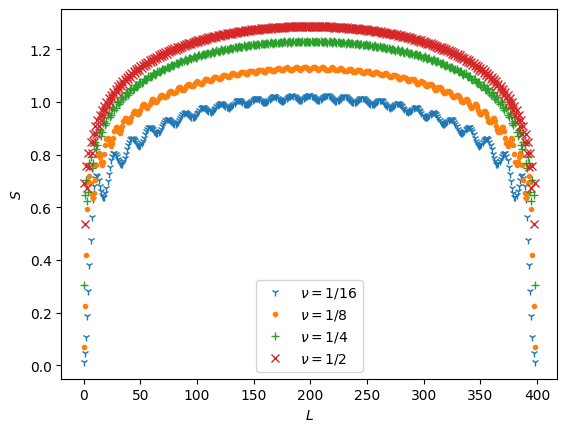

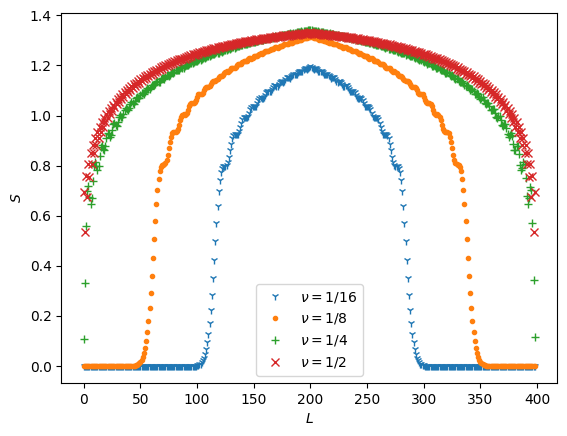

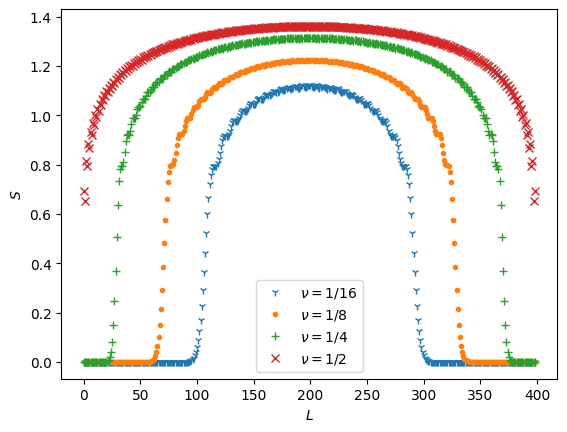

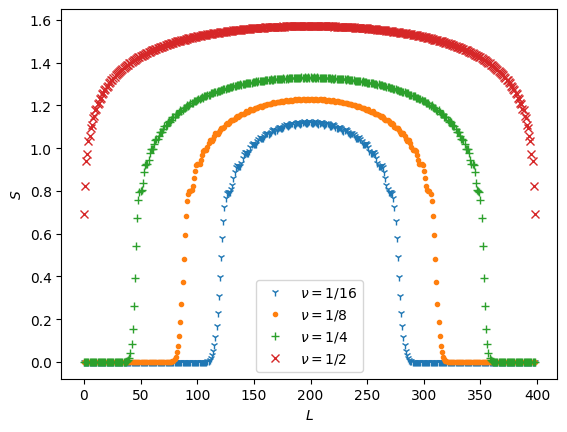

In [9]:
h = 1; J = np.exp(- h * np.abs(n/N - .5))
x = N/2 * np.sign(v) * (np.exp(h*np.abs(v)) - 1) / h 
rainbow = SpinChain(N, J, B)
rainbow.isothermal_length(x, 'c')

chains = [homogeneous, rainbow, krawtchouk, lame]

for chain, name in zip(chains, names):
    plt.figure()

    for M, m in zip([16, 8, 4, 2], ['1', '.', '+', 'x']):
        chain.diagonalise()
        chain.filling(N//M)
        print('\n', chain.M)

        plt.plot(chain.S()[:-1], m, label=fr'$\nu=1/{M}$')
        plt.xlabel('$L$')
        plt.ylabel('$S$')
    plt.legend()
    plt.savefig(f'figures/{name}_filling.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_10598/1762754129.py:5: RuntimeWarning: divide by zero encountered in divide
  A = np.nan_to_num(1 / np.sqrt(chain.J*K), posinf=0)


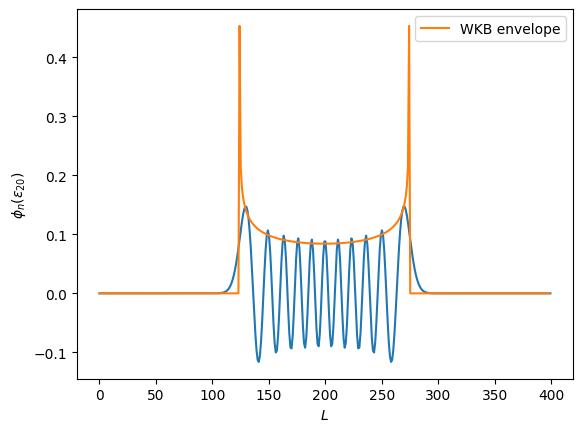

In [10]:
plt.figure()
k = 20
K = np.real(np.sqrt(2 + chain.E[k] / chain.J +0j))
K[np.abs(K) < 1e-5] = 0
A = np.nan_to_num(1 / np.sqrt(chain.J*K), posinf=0)
Phi = np.sqrt(2)*A / np.sqrt(np.sum(A**2))
plt.plot(chain.Phi[:, k])
plt.plot(Phi, label='WKB envelope')
plt.xlabel('$L$')
plt.ylabel(fr'$\phi_{{n}}(\varepsilon_{{{k}}})$')
plt.legend()
plt.savefig('figures/eigenvector.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_10598/4218861093.py:7: RuntimeWarning: divide by zero encountered in divide
  A = np.nan_to_num(1 / np.sqrt(chain.J*K), posinf=0)


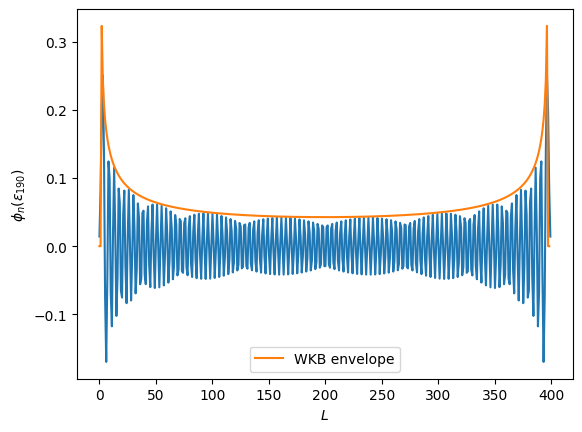

In [11]:
plt.figure()
k = 190
K = np.real(np.sqrt(1 - (chain.E[k] / (2*chain.J))**2 +0j))
#K = np.real(np.arccos((chain.E[k] / (2*chain.J))**2 +0j))
#K = np.real(np.sqrt(2 + chain.E[k] / chain.J +0j))
K[np.abs(K) < 1e-5] = 0
A = np.nan_to_num(1 / np.sqrt(chain.J*K), posinf=0)
#A = np.sqrt(np.abs(chain.E[k])) / chain.J
A[np.abs(K) < 1e-5] = 0
Phi = np.sqrt(2)*A / np.sqrt(np.sum(A**2))
plt.plot(chain.Phi[:, k])
plt.plot(Phi, label='WKB envelope')
plt.xlabel('$L$')
plt.ylabel(fr'$\phi_{{n}}(\varepsilon_{{{k}}})$')
plt.legend()

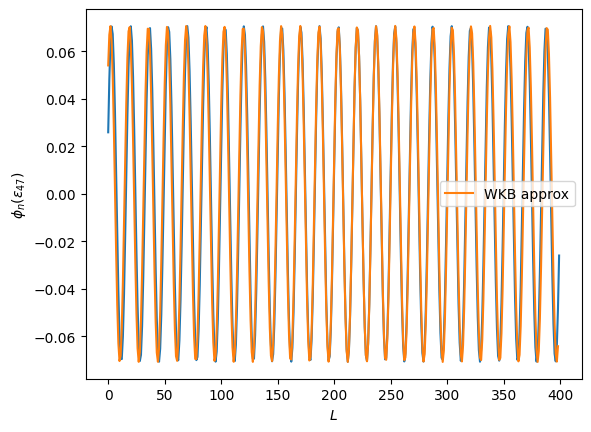

In [12]:
plt.figure()
k = 47
K = np.real(np.sqrt(2 + homogeneous.E[k] / homogeneous.J +0j))
K[np.abs(K) < 1e-5] = 0
Phi = np.sqrt(2/N)*np.cos(n*K-.7)
plt.plot(homogeneous.Phi[:, k])
plt.plot(Phi, label='WKB approx')
plt.xlabel('$L$')
plt.ylabel(fr'$\phi_{{n}}(\varepsilon_{{{k}}})$')
plt.legend()

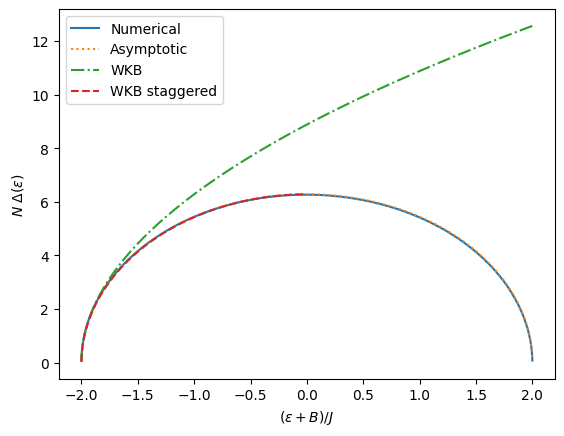

In [13]:
plt.plot(homogeneous.E[:-1], N*np.diff(homogeneous.E), label='Numerical')
plt.plot(homogeneous.E[:-1], 2*np.pi*homogeneous.J*np.sqrt(1-(homogeneous.E[:-1]/(2*homogeneous.J))**2), ':', label='Asymptotic')
K = np.real(np.sqrt(2 + homogeneous.E[:-1] / homogeneous.J +0j))
plt.plot(homogeneous.E[::2], 2*homogeneous.J[::2]*np.pi*K[::2],'-.', label='WKB')
plt.plot(homogeneous.E[:-N//2:], homogeneous.J[::2]*np.pi*K[::2],'--', label='WKB staggered')
plt.xlabel(r'$(\varepsilon+B)/J$')
plt.ylabel(r'$N\ \Delta(\varepsilon)$')
plt.legend()
plt.savefig('figures/root_spacing.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400

 25
homogeneous 1/16 	 RMSE = 0.0077,  MEAN = 0.0627,  RMSE/MEAN = 12.2919
Diagonalising L = 400 / 400

 50
homogeneous 1/8 	 RMSE = 0.0093,  MEAN = 0.1253,  RMSE/MEAN = 7.4061
Diagonalising L = 400 / 400

 100
homogeneous 1/4 	 RMSE = 0.0097,  MEAN = 0.2504,  RMSE/MEAN = 3.8799
Diagonalising L = 400 / 400

 200
homogeneous 1/2 	 RMSE = 0.0012,  MEAN = 0.5000,  RMSE/MEAN = 0.2497
Diagonalising L = 400 / 400

 25
rainbow 1/16 	 RMSE = 0.0039,  MEAN = 0.1407,  RMSE/MEAN = 2.7411


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 50
rainbow 1/8 	 RMSE = 0.0028,  MEAN = 0.1751,  RMSE/MEAN = 1.6273


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 100
rainbow 1/4 	 RMSE = 0.0093,  MEAN = 0.2506,  RMSE/MEAN = 3.7300
Diagonalising L = 400 / 400

 200
rainbow 1/2 	 RMSE = 0.0013,  MEAN = 0.5000,  RMSE/MEAN = 0.2521
Diagonalising L = 400 / 400

 25
krawtchouk 1/16 	 RMSE = 0.0038,  MEAN = 0.1304,  RMSE/MEAN = 2.9147


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 50
krawtchouk 1/8 	 RMSE = 0.0035,  MEAN = 0.1898,  RMSE/MEAN = 1.8345


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 100
krawtchouk 1/4 	 RMSE = 0.0038,  MEAN = 0.2896,  RMSE/MEAN = 1.2962


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 200
krawtchouk 1/2 	 RMSE = 0.0014,  MEAN = 0.5000,  RMSE/MEAN = 0.2891
Diagonalising L = 400 / 400

 25
lame 1/16 	 RMSE = 0.0045,  MEAN = 0.1528,  RMSE/MEAN = 2.9453


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 50
lame 1/8 	 RMSE = 0.0041,  MEAN = 0.2180,  RMSE/MEAN = 1.8699


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 100
lame 1/4 	 RMSE = 0.0041,  MEAN = 0.3212,  RMSE/MEAN = 1.2755


/tmp/ipykernel_10598/131522208.py:9: RuntimeWarning: invalid value encountered in arccos
  r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))


Diagonalising L = 400 / 400

 200
lame 1/2 	 RMSE = 0.0028,  MEAN = 0.5000,  RMSE/MEAN = 0.5504


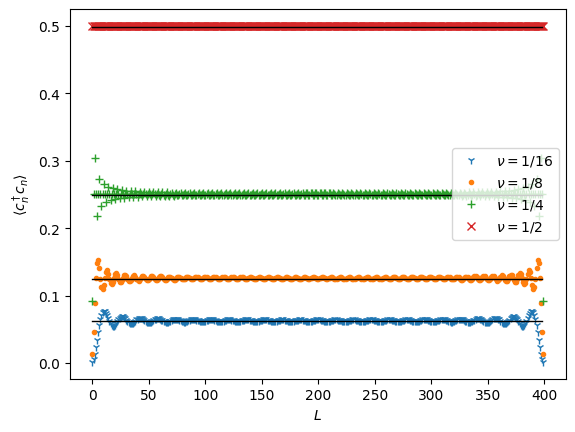

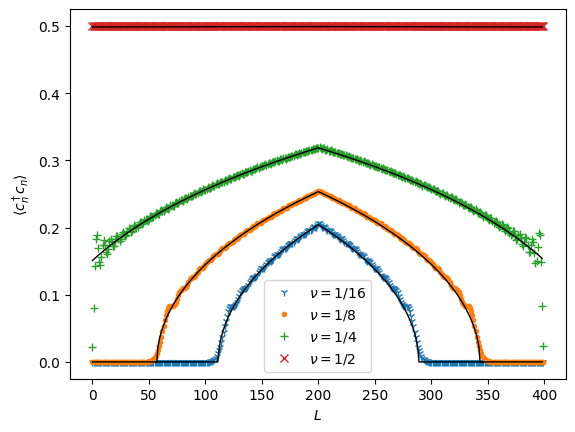

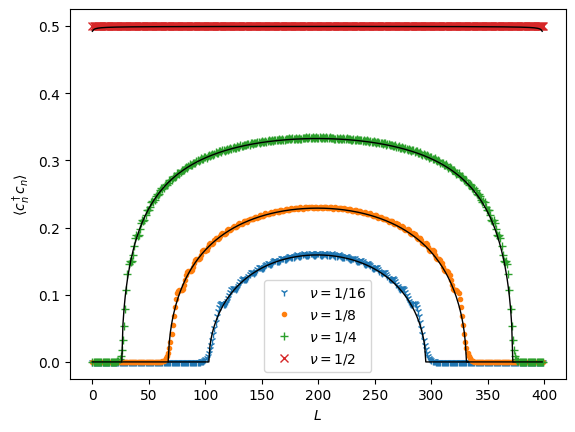

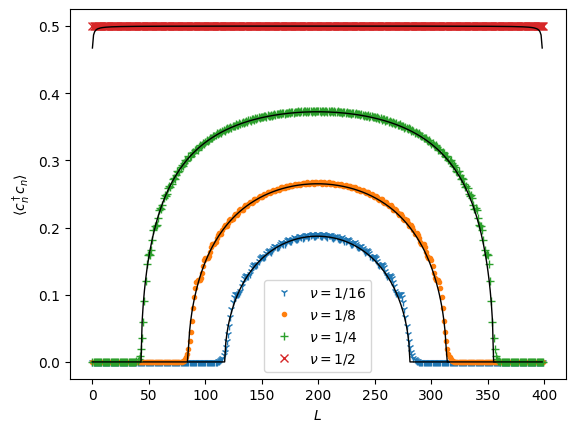

In [15]:
for chain, name in zip(chains, names):
    plt.figure()

    for M, m in zip([16, 8, 4, 2], ['1', '.', '+', 'x']):
        chain.diagonalise()
        chain.filling(N//M)
        print('\n', chain.M)

        r = 1/np.pi * np.arccos(- (chain.E[N//M - 1] + B[:-1]) / (2 * chain.J))
        r = np.nan_to_num(r)

        plt.plot(np.diag(chain.C), m, label=fr'$\nu=1/{M}$')
        plt.plot(r, 'k', lw=1)
        plt.xlabel('$L$')
        plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

        RMSE, MEAN = error((np.diag(chain.C)[:-1])[r > 0], r[r > 0])
        print(name, f'1/{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')
        
    plt.legend()
    plt.savefig(f'figures/{name}_occupation_exact.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400

 25
homogeneous 1/16 	 RMSE = 0.0077,  MEAN = 0.0627,  RMSE/MEAN = 12.2993
Diagonalising L = 400 / 400

 50
homogeneous 1/8 	 RMSE = 0.0094,  MEAN = 0.1253,  RMSE/MEAN = 7.4739
Diagonalising L = 400 / 400

 100
homogeneous 1/4 	 RMSE = 0.0121,  MEAN = 0.2504,  RMSE/MEAN = 4.8501
Diagonalising L = 400 / 400

 200
homogeneous 1/2 	 RMSE = 0.0508,  MEAN = 0.5000,  RMSE/MEAN = 10.1576
Diagonalising L = 400 / 400

 25
rainbow 1/16 	 RMSE = 0.0048,  MEAN = 0.1407,  RMSE/MEAN = 3.4135


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 50
rainbow 1/8 	 RMSE = 0.0051,  MEAN = 0.1751,  RMSE/MEAN = 2.9106


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 100
rainbow 1/4 	 RMSE = 0.0127,  MEAN = 0.2506,  RMSE/MEAN = 5.0761
Diagonalising L = 400 / 400

 200
rainbow 1/2 	 RMSE = 0.0508,  MEAN = 0.5000,  RMSE/MEAN = 10.1576
Diagonalising L = 400 / 400

 25
krawtchouk 1/16 	 RMSE = 0.0044,  MEAN = 0.1304,  RMSE/MEAN = 3.4043


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 50
krawtchouk 1/8 	 RMSE = 0.0058,  MEAN = 0.1898,  RMSE/MEAN = 3.0481


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 100
krawtchouk 1/4 	 RMSE = 0.0131,  MEAN = 0.2896,  RMSE/MEAN = 4.5231


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 200
krawtchouk 1/2 	 RMSE = 0.0508,  MEAN = 0.5000,  RMSE/MEAN = 10.1510
Diagonalising L = 400 / 400

 25
lame 1/16 	 RMSE = 0.0056,  MEAN = 0.1528,  RMSE/MEAN = 3.6471


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 50
lame 1/8 	 RMSE = 0.0078,  MEAN = 0.2180,  RMSE/MEAN = 3.5910


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 100
lame 1/4 	 RMSE = 0.0175,  MEAN = 0.3212,  RMSE/MEAN = 5.4485


/tmp/ipykernel_10598/2511848002.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400

 200
lame 1/2 	 RMSE = 0.0505,  MEAN = 0.5000,  RMSE/MEAN = 10.1066


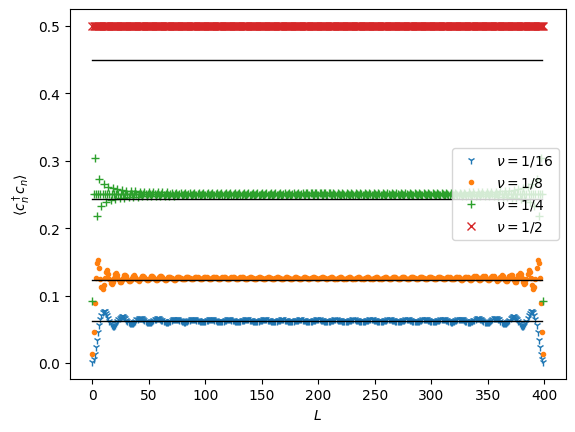

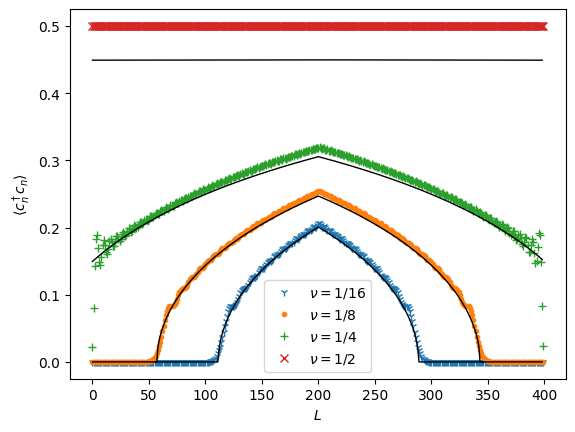

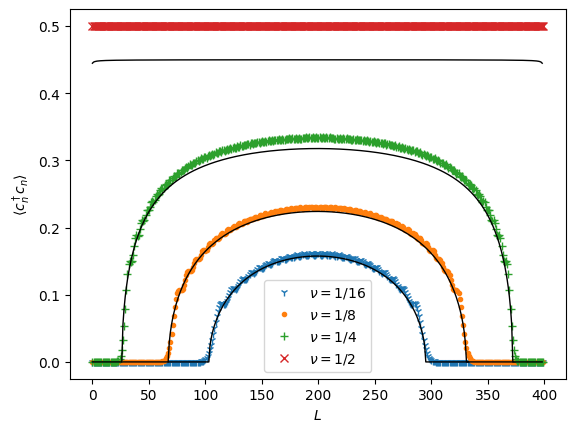

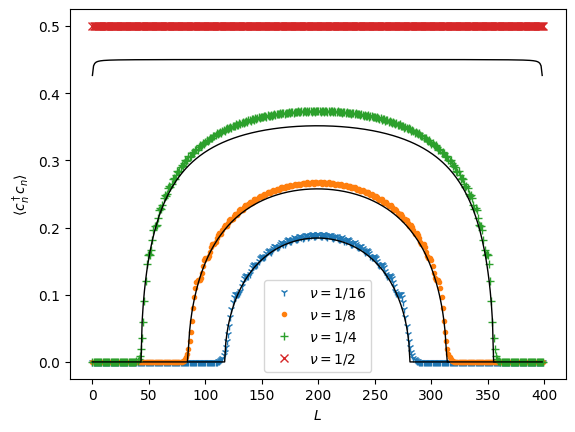

In [16]:
for chain, name in zip(chains, names):
    plt.figure()

    for M, m in zip([16, 8, 4, 2], ['1', '.', '+', 'x']):
        chain.diagonalise()
        chain.filling(N//M)
        print('\n', chain.M)

        r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)
        r = np.nan_to_num(r)

        plt.plot(np.diag(chain.C), m, label=fr'$\nu=1/{M}$')
        plt.plot(r, 'k', lw=1)
        plt.xlabel('$L$')
        plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

        RMSE, MEAN = error((np.diag(chain.C)[:-1])[r > 0], r[r > 0])
        print(name, f'1/{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')
        
    plt.legend()
    plt.savefig(f'figures/{name}_occupation.png', bbox_inches='tight', dpi=200)

In [17]:
N = 400
M = N//8

a = 1 / (N-1)
n = np.arange(0, N-1)
u = np.arange(1,N+1)/N
v = np.arange(-N//2+1, N//2+1)/N

J = np.sqrt((1+n)/N * (1 - (1+n)/N))
x = N * np.arcsin(np.sqrt(u))
krawtchouk = SpinChain(N, J, B)
krawtchouk.isothermal_length(x, 'l')

J = np.sqrt(((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N))
x = N * special.ellipkinc(np.arcsin(2*v), (1 - 1/N)**2)
x[-1] = N * special.ellipk((1 - 1/N)**2)
lame = SpinChain(N, J, B)
lame.isothermal_length(x, 'c')

Diagonalising L = 400 / 400
lame 1/50 	 RMSE = 0.2404,  MEAN = 0.5000,  RMSE/MEAN = 48.0856


/tmp/ipykernel_10598/781998251.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)


Diagonalising L = 400 / 400
lame 1/50 	 RMSE = 0.3187,  MEAN = 0.5000,  RMSE/MEAN = 63.7444


/tmp/ipykernel_10598/781998251.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)


Diagonalising L = 400 / 400
lame 1/50 	 RMSE = 0.2387,  MEAN = 0.5000,  RMSE/MEAN = 47.7381


/tmp/ipykernel_10598/781998251.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)


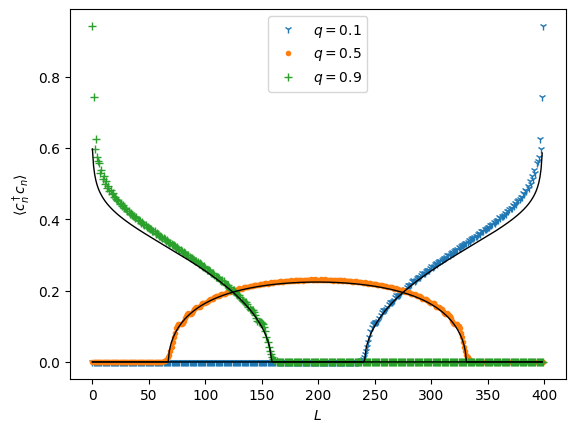

In [18]:
plt.figure()
for q, m in zip([.1, .5, .9], ['1', '.', '+', 'x']):
    n = np.arange(0, N-1)
    J = np.sqrt(q*(1-q) * (1+n)/N * (1 - (1+n)/N))
    n = np.arange(0, N)
    B = q * (1 - 1/N) + (1 - 2*q) * n/N
    krawtchouk.J = J
    krawtchouk.B = B
    krawtchouk.diagonalise()
    krawtchouk.filling(M)

    r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)
    r = np.nan_to_num(r)

    plt.plot(np.diag(krawtchouk.C), m, label=fr'$q={q}$')
    plt.plot(r, 'k', lw=1, zorder=10)
    plt.xlabel('$L$')
    plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

    RMSE, MEAN = error((np.diag(chain.C)[:-1])[r > 0], r[r > 0])
    print(name, f'1/{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')

plt.legend()
plt.savefig(f'figures/krawtchouk_B.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400
lame 1/50 	 RMSE = 0.2659,  MEAN = 0.5000,  RMSE/MEAN = 53.1775


/tmp/ipykernel_10598/686557827.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)


Diagonalising L = 400 / 400
lame 1/50 	 RMSE = 0.2942,  MEAN = 0.5000,  RMSE/MEAN = 58.8327


/tmp/ipykernel_10598/686557827.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)


Diagonalising L = 400 / 400
lame 1/50 	 RMSE = 0.3545,  MEAN = 0.5000,  RMSE/MEAN = 70.9029


/tmp/ipykernel_10598/686557827.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)


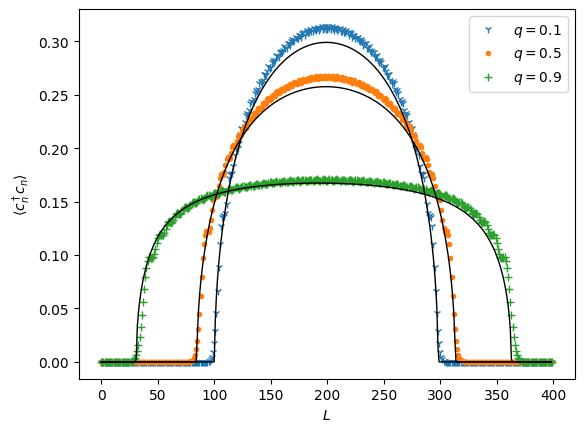

In [19]:
plt.figure()
for q, m in zip([.1, .5, .9], ['1', '.', '+', 'x']):
    n = np.arange(0, N-1)
    J = np.sqrt(((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N))
    n = np.arange(0, N)
    B = -.5 * (1 - 2*q) * ((2*n + 1) / N - 1)**2
    lame.J = J
    lame.B = B
    lame.diagonalise()
    lame.filling(M)

    r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)
    r = np.nan_to_num(r)

    plt.plot(np.diag(lame.C), m, label=fr'$q={q}$')
    plt.plot(r, 'k', lw=1, zorder=10)
    plt.xlabel('$L$')
    plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

    RMSE, MEAN = error((np.diag(chain.C)[:-1])[r > 0], r[r > 0])
    print(name, f'1/{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')

plt.legend()
plt.savefig(f'figures/lame_B.png', bbox_inches='tight', dpi=200)